Epoch 7 [Validation]:  69%|██████▊   | 68600/99970 [09:03<01:21, 384.70it/s, loss=2.5]     

Epoch 00007: reducing learning rate of group 0 to 1.0000e-05.


Epoch 10 [Validation]:  98%|█████████▊| 98000/99970 [12:25<00:14, 131.54it/s, loss=2.22]    


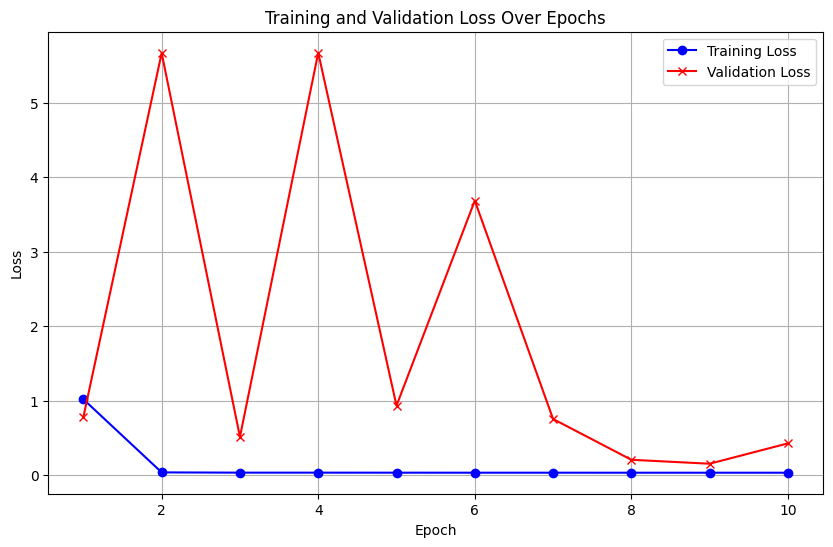

In [30]:
import os
import json
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import matplotlib.pyplot as plt


class MazeGameDataset(Dataset):
    # Adding reverse mapping
    def __init__(self, image_dir, action_file):
        self.image_dir = image_dir
        self.actions = self._load_actions(action_file)
        self.num_actions = 4
        self.action_index = {'up': 0, 'down': 1, 'left': 2, 'right': 3}
        self.index_action = {v: k for k, v in self.action_index.items()}  # Reverse mapping
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) # why these values? 
        ])

    def action_to_one_hot(self, action):
        one_hot = torch.zeros(self.num_actions)
        one_hot[self.action_index[action]] = 1
        return one_hot

    def one_hot_to_action(self, one_hot):
        index = one_hot.argmax().item()
        return self.index_action[index]

    def _load_actions(self, action_file):
        with open(action_file, 'r') as f:
            actions = json.load(f)
        return actions

    def __len__(self):
        return len(self.actions) - 1

    def __getitem__(self, idx):
        action = self.actions[str(idx+1)]
        
        if action is None: 
            idx += 1
            action = self.actions[str(idx+1)]
            if action is None: 
                idx += 1

        frame_file = os.path.join(self.image_dir, f"{idx}.png")
        next_frame_file = os.path.join(self.image_dir, f"{idx + 1}.png")

        frame = Image.open(frame_file).convert('RGB')
        next_frame = Image.open(next_frame_file).convert('RGB')

        frame = self.transform(frame)
        next_frame = self.transform(next_frame)
        
        action = self.actions[str(idx+1)]

        # print(action)
        action_one_hot = self.action_to_one_hot(action)

        action_one_hot = action_one_hot.view(self.num_actions, 1, 1)
        action_channel = action_one_hot.expand(-1, frame.shape[1], frame.shape[2])
        frame_with_action = torch.cat((frame, action_channel), dim=0)

        return frame_with_action, next_frame


class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        total_in_channels = in_channels + out_channels
        self.conv = nn.Conv2d(in_channels=total_in_channels, out_channels=4 * out_channels, kernel_size=kernel_size, padding=padding)

        
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size).to(device))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size).to(device))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size).to(device))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C
    
    def reset_parameters(self):
        # Kaiming He initialization for ReLU
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv.bias, 0)

        # Xavier Glorot initialization for Tanh
        nn.init.xavier_normal_(self.W_ci)
        nn.init.xavier_normal_(self.W_co)
        nn.init.xavier_normal_(self.W_cf)

class ConvLSTM(nn.Module):
    
    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, kernel_size, padding, activation, frame_size)


    def forward(self, X):
        batch_size, _, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size, self.out_channels, height, width, device=device)

        # Process the single frame
        H, C = self.convLSTMcell(X, H, C)
        output = H

        return output
    
    def reset_parameters(self):
        self.convLSTMcell.reset_parameters()


class Seq2Seq(nn.Module):
    def __init__(self, num_channels, num_actions, num_kernels, kernel_size, padding, 
                 activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        in_channels = num_channels + num_actions  # RGB channels + action encodings

        self.sequential = nn.Sequential()

        # First layer with in_channels as 8
        self.sequential.add_module("convlstm1", ConvLSTM(in_channels=num_channels+num_actions, out_channels=num_kernels, kernel_size=kernel_size, padding=padding, activation=activation, frame_size=frame_size))

        for l in range(2, num_layers + 1):
            self.sequential.add_module(f"convlstm{l}", ConvLSTM(in_channels=num_kernels, out_channels=num_kernels, kernel_size=kernel_size, padding=padding, activation=activation, frame_size=frame_size))
                
            self.sequential.add_module(f"batchnorm{l}", nn.BatchNorm2d(num_features=num_kernels))


        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,  # Outputting RGB channels
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):
        # Forward propagation through all the layers
        output = self.sequential(X)

        # Process the last output frame
        output = self.conv(output)
        
        return nn.Sigmoid()(output)
    
    def reset_parameters(self):
        for layer in self.sequential:
            if hasattr(layer, 'reset_parameters'):
                layer.reset_parameters()

        # Initialize the final convolution layer
        nn.init.kaiming_normal_(self.conv.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv.bias, 0)
        
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, inputs, targets):
        # Flatten inputs and targets
        inputs_flat = inputs.view(inputs.size(0), -1)
        targets_flat = targets.view(targets.size(0), -1)

        # Compute weighted MSE
        diff = inputs_flat - targets_flat
        loss = (self.weights * diff ** 2).sum()

        return loss

def train(model, dataloader, criterion, optimizer, device, pbar):
    model.train()
    total_loss = 0
    update_count = 100 
    iters = 0
    for input, target in dataloader:
        iters += 1
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(input)
        loss = criterion(output.flatten(), target.flatten()) / output.numel()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if iters % update_count == 0: 
                # Update tqdm progress bar
            pbar.set_description(f"Epoch {epoch} [Training]")
            pbar.set_postfix(loss=loss.item())
            pbar.update(update_count)

    return total_loss / len(dataloader)

def validate(model, dataloader, criterion, device, pbar):
    model.eval()
    total_loss = 0
    update_count = 100
    with torch.no_grad():
        iters = 0
        for input, target in dataloader:
            iters += 1
            input, target = input.to(device), target.to(device)
            output = model(input)
            loss = criterion(output.flatten(), target.flatten()) / output.numel()
            total_loss += loss.item()
            if iters % update_count == 0: 

                        # Update tqdm progress bar
                pbar.set_description(f"Epoch {epoch} [Validation]")
                pbar.set_postfix(loss=loss.item())
                pbar.update(update_count)

    return total_loss / len(dataloader)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        """
        Early stops the training if validation loss doesn't improve after a given patience.
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_loss):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
            
def save_checkpoint(model, optimizer, scheduler, epoch, loss, learning_rate, batch_size, folder='lstm_rgb_checkpoints'):
    if not os.path.exists(folder):
        os.makedirs(folder)

    filename = f'checkpoint_lr_{learning_rate}_bs_{batch_size}_epoch_{epoch}.pth.tar'
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'scheduler': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(state, os.path.join(folder, filename))
            
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Adjust the learning rate
learning_rate = 1e-4
batch_size = 1
num_epochs = 10

model = Seq2Seq(num_channels=3, num_actions=4, num_kernels=64, kernel_size=(3, 3), padding=(1, 1), activation="relu", frame_size=(32, 32), num_layers=5).to(device)
model.reset_parameters()

optim = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min', factor=0.1, patience=3, verbose=True)


total_channels = 3 + 4 #num_channels + num_actions



weights = torch.tensor([100.0, 100.0, 1.0] + [1.0] * (total_channels - 3))  # Higher weights for RGB channels
weights = weights.to(device)
criterion = WeightedMSELoss(weights)

# Split the dataset
train_dataset = MazeGameDataset(image_dir="image_data", action_file="move_mapping.json")
val_dataset = MazeGameDataset(image_dir="image_data", action_file="move_mapping.json")

# Assuming the dataset returns images in a sequential manner
train_dataset = torch.utils.data.Subset(train_dataset, range(2,8000))
val_dataset = torch.utils.data.Subset(val_dataset, range(8000, 9999))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

train_losses, val_losses = [], []
early_stopping = EarlyStopping(patience=2)


total_iterations = num_epochs * (len(train_loader) + len(val_loader))

with tqdm(total=total_iterations, desc="Overall Progress", leave=True) as pbar:
    for epoch in range(1, num_epochs + 1):
        # Train and validate with the same progress bar
        train_loss = train(model, train_loader, criterion, optim, device, pbar)
        val_loss = validate(model, val_loader, criterion, device, pbar)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Update the learning rate scheduler
        scheduler.step(val_loss)
        
        save_checkpoint(model, optim, scheduler, epoch, val_loss, learning_rate, batch_size)

        # # Early stopping logic
        # early_stopping(val_loss)
        # if early_stopping.early_stop:
        #     print("Early stopping triggered.")
        #     break
                
actual_num_epochs = len(train_losses)  # Length of train_losses or val_losses should be the same

plt.figure(figsize=(10, 6))
epochs = range(1, actual_num_epochs + 1)  # Adjusting the range to actual number of epochs
plt.plot(epochs, train_losses, label='Training Loss', color='blue', marker='o')
plt.plot(epochs, val_losses, label='Validation Loss', color='red', marker='x')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Qualitative Analysis

In [36]:
import random
import matplotlib.pyplot as plt
from torchvision import transforms

def load_checkpoint(filepath, model, optimizer=None, scheduler=None):
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer and 'optimizer' in checkpoint:
        optimizer.load_state_dict(checkpoint['optimizer'])
    if scheduler and 'scheduler' in checkpoint:
        scheduler.load_state_dict(checkpoint['scheduler'])
    return checkpoint['epoch'], checkpoint.get('loss', float('inf'))

def preprocess_image(image_tensor, action_one_hot):
    """ Preprocess the image and action for model input """
    action_channel = action_one_hot.view(-1, 1, 1).expand(-1, image_tensor.shape[1], image_tensor.shape[2])
    return torch.cat((image_tensor, action_channel), dim=0).unsqueeze(0)  # Add batch dimension

def postprocess_image(image_tensor):
    """ Postprocess the model output to viewable image """
    return transforms.functional.to_pil_image(image_tensor.squeeze(0))  # Remove batch dimension and convert to PIL image

# eval_model = Seq2Seq(num_channels=3, num_actions=4, num_kernels=64, kernel_size=(3, 3), padding=(1, 1), activation="relu", frame_size=(32, 32), num_layers=5)
eval_model = model
eval_model = eval_model.to(device)



# Load the checkpoint
checkpoint_path = 'lstm_rgb_checkpoints/checkpoint_lr_0.0001_bs_1_epoch_10.pth.tar'  # Replace with your checkpoint path
load_checkpoint(checkpoint_path, eval_model)

# Set the model to evaluation mode
eval_model.eval()
eval_dataset = val_dataset 


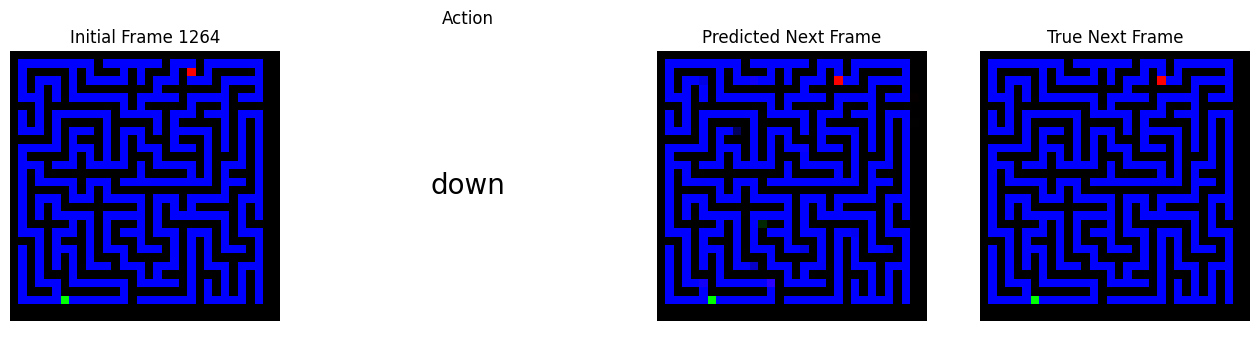

In [41]:

# Randomly select a sample from the validation dataset
random_idx = random.randint(0, len(eval_dataset) - 1)
frame_with_action, true_next_frame = eval_dataset[random_idx]

# Extract the initial frame and action for visualization
initial_frame = frame_with_action[:3, :, :]  # First 3 channels are the initial frame
action_one_hot = frame_with_action[3:, 0, 0]  # Action channels

# Transform the initial frame back to PIL for visualization
initial_image = transforms.functional.to_pil_image(initial_frame)

# Transform the true next frame back to PIL for visualization
true_next_image = transforms.functional.to_pil_image(true_next_frame)

# Prepare the input tensor for the model
input_tensor = preprocess_image(initial_frame, action_one_hot)

with torch.no_grad():
    predicted_frame = eval_model(input_tensor.to(device))

# Postprocess the predicted image
predicted_image = postprocess_image(predicted_frame.cpu())

original_dataset = eval_dataset.dataset

# Decode the one-hot action to a string
action = original_dataset.one_hot_to_action(action_one_hot)

# Plotting
fig, axs = plt.subplots(1, 4, figsize=(16, 4))  # Create a figure with 4 subplots

# Display the initial frame
axs[0].imshow(initial_image)
axs[0].set_title(f"Initial Frame {random_idx}")
axs[0].axis('off')

# Display the action
axs[1].text(0.5, 0.5, action, ha='center', va='center', fontsize=20)
axs[1].set_title("Action")
axs[1].axis('off')

# Display the predicted next frame
axs[2].imshow(predicted_image)
axs[2].set_title("Predicted Next Frame")
axs[2].axis('off')

# Display the true next frame
axs[3].imshow(true_next_image)
axs[3].set_title("True Next Frame")
axs[3].axis('off')

plt.show()
